# Failure probability calculations with a fragility curve

In this example, we will demonstrate how to calculate the failure probability of a levee using a fragility curve.

Fragility curve is a function that describes the relation between the load imposed on the levee and the corresponding  (conditional) failure probability. Typically a fragility curve is expressed by the following relation: $h \rightarrow P(Z<0|h)$. By integrating the fragility curve with the load statistics, the failure probability can be estimated. The goal is to derive the following probability: 

$P(Z<0) = \int P(Z<0 | h)\cdot f(h) dh$

First, let's import the necessary packages:

In [1]:
from probabilistic_library import ReliabilityProject, DistributionType, ReliabilityMethod, FragilityCurve, FragilityValue, Stochast
import matplotlib.pyplot as plt
import numpy as np

We consider the Hunt's limit state function:

In [2]:
from utils.models import hunt

We define a reliability project using the `ReliabilityProject()` class and refer to the Hunt's limit state function:

In [3]:
project = ReliabilityProject()
project.model = hunt

project.model.print()

Model hunt:
Input parameters:
  t_p
  tan_alpha
  h_s
  h_crest
  h
Output parameters:
  Z


We define the associated variables, except for the water level variable, $h$:

In [4]:
project.variables["t_p"].distribution = DistributionType.log_normal
project.variables["t_p"].mean = 6
project.variables["t_p"].deviation = 2

project.variables["tan_alpha"].distribution = DistributionType.deterministic
project.variables["tan_alpha"].mean = 0.333333

project.variables["h_s"].distribution = DistributionType.log_normal
project.variables["h_s"].mean = 3
project.variables["h_s"].deviation = 1

project.variables["h_crest"].distribution = DistributionType.log_normal
project.variables["h_crest"].mean = 10
project.variables["h_crest"].deviation = 0.05

We choose the `form` calculation method:

In [5]:
project.settings.reliability_method = ReliabilityMethod.form
project.settings.relaxation_factor = 0.15
project.settings.maximum_iterations = 50
project.settings.epsilon_beta = 0.01

Next, we construct the fragility curve using the `FragilityCurve()` class, providing the water level variable $h$. Reliability calculations are performed for each value of the water level variable.

In [6]:
fragility_curve = FragilityCurve()
fragility_curve.name = "conditional"

fc_pf = []
h = np.arange(-2.0, 5.0, 0.25)
for val in h:

        project.variables["h"].distribution = DistributionType.deterministic
        project.variables["h"].mean = val
        project.run()
        dp = project.design_point
        
        value = FragilityValue()
        value.x = val
        value.reliability_index = dp.reliability_index
        value.design_point = dp
        
        fragility_curve.fragility_values.append(value)
        fc_pf.append(dp.probability_failure)

The calculations above result in a fragility curve:

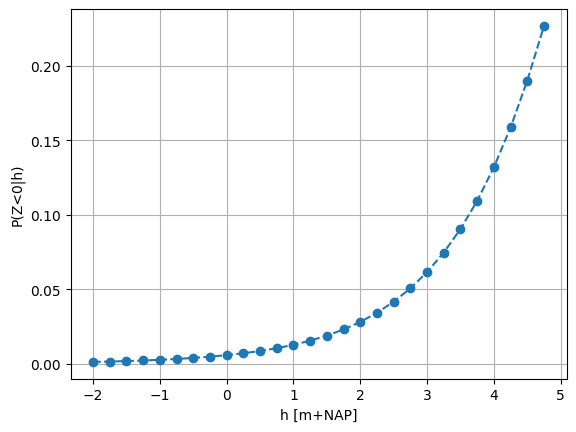

In [7]:
plt.plot(h, fc_pf, 'o--')
plt.grid()
plt.xlabel("h [m+NAP]")
plt.ylabel("P(Z<0|h)")
plt.show()

The load $h$ is the integrand and follows an exponential distribution:

In [76]:
integrand = Stochast()
integrand.name = "h"
integrand.distribution = DistributionType.exponential
integrand.shift = 0.5
integrand.scale = 1.0

The integration of the fragility curve with the water level statistics is performed as follows:

In [77]:
dp = fragility_curve.integrate(integrand)

The results are:

In [78]:
dp.print()

Reliability:
 Reliability index = 1.8853
 Probability of failure = 0.0297
 Convergence = 0.0 (converged)
 Model runs = 16001
Alpha values:
 h: alpha = -0.5209, x = 2.3137
 t_p: alpha = -0.8555, x = 9.6084
 h_s: alpha = -0.4226, x = 3.6859
 h_crest: alpha = 0.0168, x = 9.9983



Reliability calculations performed without the fragility curve, but instead using the distribution function for the water level $h$, should yield results that are close to those obtained using the fragility curve.

We begin with the `form` method, which provides a reliability index that deviates from the one obtained from the integration of the water level distribution with the fragility curve. It is expected that the method has converged to a local optimum in this case.

In [79]:
project.variables["h"].distribution = DistributionType.exponential
project.variables["h"].shift = 0.5
project.variables["h"].scale = 1.0

project.run()

project.design_point.print()

Reliability (FORM)
 Reliability index = 2.0502
 Probability of failure = 0.0202
 Convergence = 0.0089 (converged)
 Model runs = 165
Alpha values:
 t_p: alpha = -0.7813, x = 9.5736
 tan_alpha: alpha = 0.0, x = 0.3333
 h_s: alpha = -0.3859, x = 3.6793
 h_crest: alpha = 0.0154, x = 9.9983
 h: alpha = -0.4904, x = 2.3491



The results are improved, when the `crude_monte_carlo` method is used:

In [80]:
project.settings.reliability_method = ReliabilityMethod.crude_monte_carlo
project.settings.minimum_samples = 1000
project.settings.maximum_samples = 50000
project.settings.variation_coefficient = 0.02

project.run()

project.design_point.print()

Reliability:
 Reliability index = 1.8832
 Probability of failure = 0.0298
 Convergence = 0.0255 (not converged)
 Model runs = 50001
Alpha values:
 t_p: alpha = -0.7713, x = 9.1209
 tan_alpha: alpha = 0.0, x = 0.3333
 h_s: alpha = -0.3697, x = 3.5677
 h_crest: alpha = 0.0401, x = 9.9961
 h: alpha = -0.5164, x = 2.2994

